In [1]:
import numpy as np
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
import utils.data
from utils.model import transformer_classifier
from utils.layers import *
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import normalize
import seaborn as sns

In [2]:
data = utils.data.get_dataset(mode='mel')

In [3]:
data_length = len(data["mfcc"])
train_ratio = 0.7
valid_ratio = 0.2
test_ratio = 0.1

X_train = []
Y_train = []
X_valid = []
Y_valid = []
X_test = []
Y_test = []

for i in range(len(data["mapping"])):
    data_length = data["labels"].count(i)
    start = data["labels"].index(i)
    train_size = int(train_ratio*data_length)
    valid_size = int(valid_ratio*data_length)
    test_size = int(test_ratio*data_length)

    for element in data["mfcc"][start:start+train_size]:
        X_train.append(element)
    for element in data["labels"][start:start+train_size]:
        Y_train.append(element)
    for element in data["mfcc"][start+train_size:start+train_size+valid_size]:
        X_valid.append(element)
    for element in data["labels"][start+train_size:start+train_size+valid_size]:
        Y_valid.append(element)
    for element in data["mfcc"][start+train_size+valid_size:start+train_size+valid_size+test_size]:
        X_test.append(element)
    for element in data["labels"][start+train_size+valid_size:start+train_size+valid_size+test_size]:
        Y_test.append(element)

In [4]:
X_train=np.array(X_train)
Y_train=np.array(Y_train)
X_valid=np.array(X_valid)
Y_valid=np.array(Y_valid)
X_test=np.array(X_test)
Y_test=np.array(Y_test)

In [5]:
mean = np.mean(X_train, axis=0)
std  = np.std(X_train, axis=0, dtype=np.float32)

In [6]:
# X_train = (X_train - mean) / std
# X_valid = (X_valid - mean) / std
# X_test  = (X_test - mean) / std

In [7]:
Y_train = to_categorical(Y_train)
Y_valid = to_categorical(Y_valid)
Y_test  = to_categorical(Y_test)

In [8]:
num_samples = X_train.shape[0]

# Generate a random permutation of indices
random_indices = np.random.permutation(num_samples)

# Shuffle X_train and Y_train using the random indices
X_train = X_train[random_indices]
Y_train = Y_train[random_indices]

In [9]:
num_layers=4
d_model=utils.data.n_mfcc_mel
num_heads=3
dff=128
maximum_position_encoding=2048 #utils.data.num_mfcc_vectors_per_segment
n_classes=len(data["mapping"])

In [10]:
model = transformer_classifier(num_layers, d_model, num_heads, dff, maximum_position_encoding, n_classes)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, 128)]  0           []                               
                                                                                                  
 encoder (Encoder)              (None, None, 128)    925696      ['input_1[0][0]']                
                                                                                                  
 encoder_1 (Encoder)            (None, None, 128)    925696      ['input_1[0][0]']                
                                                                                                  
 dropout_39 (Dropout)           (None, None, 128)    0           ['encoder[0][0]']                
                                                                                              

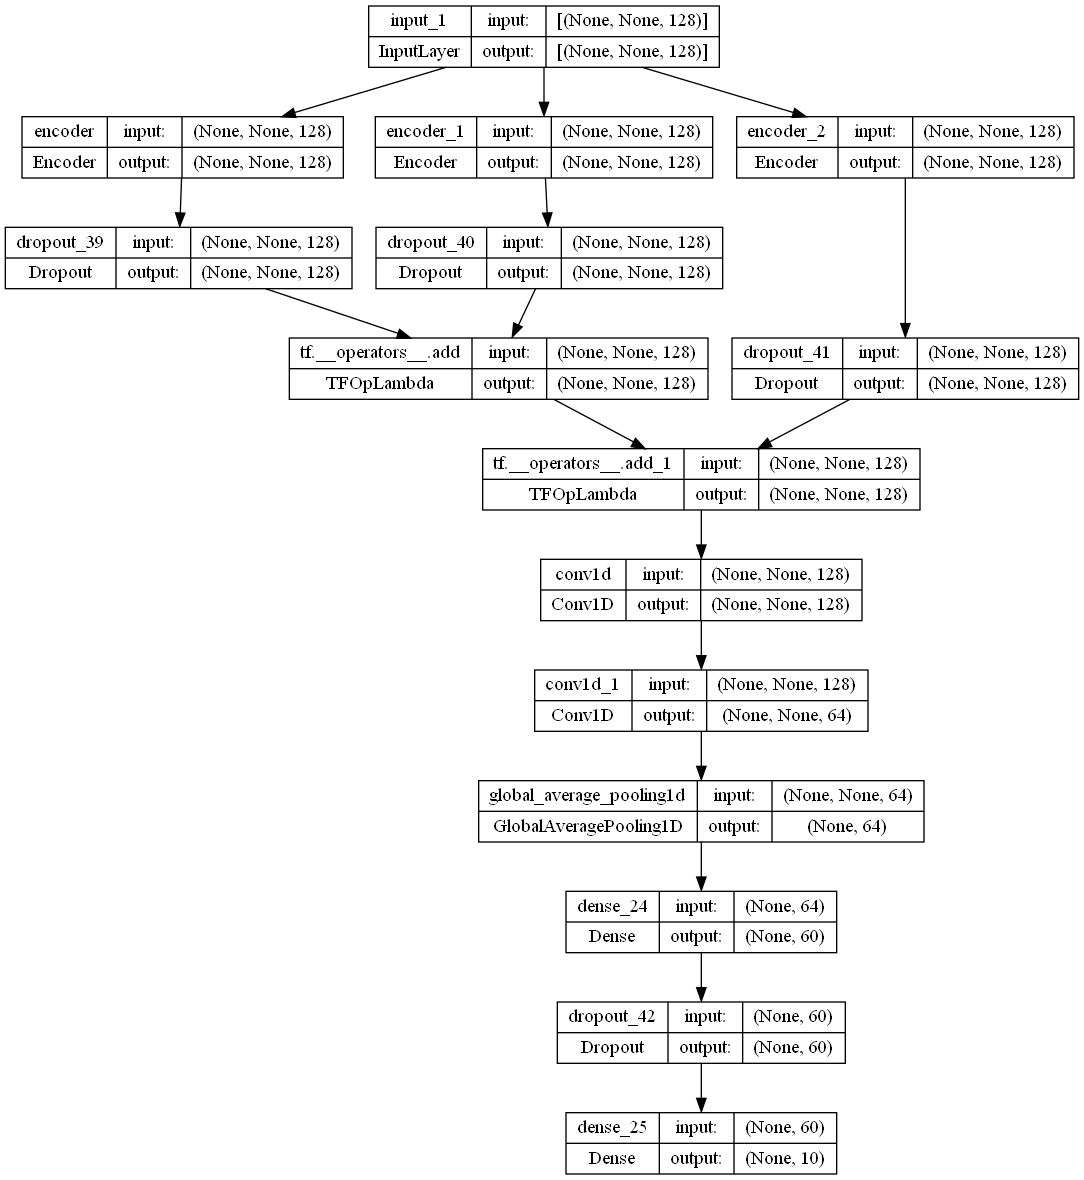

In [11]:
tf.keras.utils.plot_model(model,"model.png", show_shapes = True,)

In [12]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='auto', verbose=1, patience=5, restore_best_weights=True)

In [13]:
reduce_o_p = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_accuracy", patience=20, min_lr=1e-7, mode="min")

In [14]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(
        "./models/transformer.h5",
        monitor="val_accuracy",
        verbose=1,
        save_best_only=True,
        mode="auto",
        save_weights_only=True,
    )

In [15]:
model.fit(X_train, Y_train, epochs=50, batch_size=32, validation_data=(X_valid, Y_valid), callbacks=[checkpoint, es])

Epoch 1/50
219/219 [==============================] - ETA: 0s - loss: 1.9430 - accuracy: 0.4380
Epoch 1: val_accuracy improved from -inf to 0.31394, saving model to ./models\transformer.h5
219/219 [==============================] - 35s 106ms/step - loss: 1.9430 - accuracy: 0.4380 - val_loss: 2.9527 - val_accuracy: 0.3139
Epoch 2/50
219/219 [==============================] - ETA: 0s - loss: 1.0778 - accuracy: 0.6333
Epoch 2: val_accuracy improved from 0.31394 to 0.46289, saving model to ./models\transformer.h5
219/219 [==============================] - 22s 98ms/step - loss: 1.0778 - accuracy: 0.6333 - val_loss: 2.5425 - val_accuracy: 0.4629
Epoch 3/50
219/219 [==============================] - ETA: 0s - loss: 0.8088 - accuracy: 0.7237
Epoch 3: val_accuracy improved from 0.46289 to 0.50853, saving model to ./models\transformer.h5
219/219 [==============================] - 21s 98ms/step - loss: 0.8088 - accuracy: 0.7237 - val_loss: 1.9096 - val_accuracy: 0.5085
Epoch 4/50
219/219 [=======

In [ ]:
print("predicted:\t",np.argmax(model.predict(tf.expand_dims(X_test[55], axis=0))))
print("actual:\t\t",np.argmax(Y_test[55]))

1/1 [==============================] - 1s 1s/step
predicted:	 2
actual:		 0


32/32 [==============================] - 2s 34ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       100
           1       0.85      0.84      0.84        99
           2       0.39      0.72      0.51        99
           3       0.71      0.70      0.70        99
           4       0.58      0.78      0.66        99
           5       0.71      0.60      0.65        99
           6       0.43      0.91      0.59       100
           7       0.77      0.84      0.80       100
           8       0.50      0.19      0.28       100
           9       0.50      0.15      0.23       100

    accuracy                           0.57       995
   macro avg       0.54      0.57      0.53       995
weighted avg       0.54      0.57      0.53       995



<Axes: >

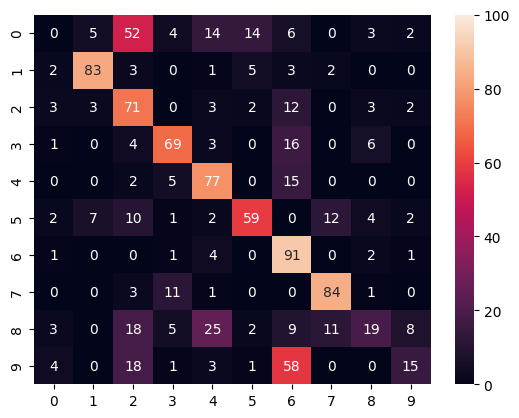

In [ ]:
preds = model.predict(X_test)
print(classification_report(np.argmax(Y_test,1),np.argmax(preds,1)))
conf=confusion_matrix(np.argmax(Y_test,1),np.argmax(preds,1))
dia= sns.heatmap(conf, annot=True, fmt='d', vmax=100)
dia.set_xticklabels(data["mapping"], rotation=90)
dia.set_yticklabels(data["mapping"], rotation=0)

In [ ]:
for i in range(len(data["mapping"])):
    print(str(i) + ":\t" + data["mapping"][i])

0:	blues
1:	classical
2:	country
3:	disco
4:	hiphop
5:	jazz
6:	metal
7:	pop
8:	reggae
9:	rock


In [ ]:
# pred_model = model.load_weights("./models/transformer2.h5")

In [ ]:
np.argmax(model.predict(tf.expand_dims(X_test[55], axis=0)))

1/1 [==============================] - 0s 37ms/step


2

In [ ]:
import librosa
from utils.data import *

In [ ]:
def predict_genre(signal, sr):
    segments = []
    for i in range(number_of_segments):
        # calculating start and finish index of the segment
        start = samples_per_segment * i
        end = start + samples_per_segment
        # Calculating the mfcc of the segment
        feature = librosa.feature.melspectrogram(y=signal[start:end], sr=sr, n_mels=n_mfcc_mel, n_fft=n_fft, hop_length=hop_length)
        feature = (librosa.power_to_db(feature, ref=np.max) + 40) / 40
        feature = feature.T.tolist()
        if len(feature) == num_mfcc_vectors_per_segment:
            # Adding the mfcc and label to our data
            segments.append(feature)
        
    segments = np.array(segments)
    sum = np.zeros(10)
    for segment in segments:
        sum[np.argmax(model.predict(tf.expand_dims(segment, axis=0), verbose=0))] += 1
    pred = np.argmax(sum)
    return data["mapping"][pred]
    